In [1]:
import numpy as np
from bposd.hgp import hgp
from bposd.css_decode_sim import css_decode_sim
from quantum_code import *
import matplotlib.pyplot as plt
from classical_code import *
from ldpc import bposd_decoder, bp_decoder
import galois
from numpy.linalg import matrix_power, matrix_rank
from bposd.css import css_code

In [7]:
qubit_error_rate = 0.01
# qcode = read_qcode("../codes/qcodes/HGP_400_16/HGP_400_16.qcode")

qcode = read_qcode("../codes/qcodes/HGP_100_4/HGP_C642_150_4.qcode")

Hx, Hz, Lx, Lz = qcode.to_numpy()

bposd_qec_dec = bposd_decoder(
    Hx,
    error_rate=qubit_error_rate,
    bp_method="ms",
    max_iter=Hx.shape[1],
    osd_method="osd0",
    # osd_order=40
)

c:\Users\nfber\anaconda3\envs\qc\lib\site-packages\ldpc\_legacy_ldpc_v1\_legacy_bposd_decoder.py:37: UserWarning: This is the old syntax for the `bposd_decoder` from `ldpc v1`. Use the `BpOsdDecoder` class from `ldpc v2` for additional features.
  warnings.warn("This is the old syntax for the `bposd_decoder` from `ldpc v1`. Use the `BpOsdDecoder` class from `ldpc v2` for additional features.")


In [8]:

osd_options={
'error_rate': 0.01,
'target_runs': 10000,
'xyz_error_bias': [0, 0, 1],
'output_file': 'test.json',
'max_iter': Hx.shape[1],
'bp_method': "msl",
'ms_scaling_factor': 0,
'osd_method': "osd0",
'osd_order': 0,
'channel_update': None,
'seed': 42,
'max_iter': 0,
'output_file': "test.json"
}

lk = css_decode_sim(hx=Hx, hz=Hz, **osd_options)

RNG Seed: 42
Constructing CSS code from hx and hz matrices...


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all().

In [42]:
from math import comb

def prob(n, p):
    p_sum = 0
    for k in range(n//2):
        p_sum += comb(n, 2*k+1) * p**(2*k+1) * (1-p)**(n-(2*k+1))
    return p_sum

prob(16, 1e-3)

0.015762225509632473

In [117]:
deltaV = 14
deltaC = 16

n = 4
p = 0.001

num_non_adaptive_CNOTs = []
num_adaptive_CNOTs = []
num_non_adaptive_gens = []
num_adaptive_gens = []
iss = []

for i in range(100, 10000):
    if (i % (n-2) == 0):
        iss.append(i)
        num_non_adaptive_CNOTs.append(i * deltaV)
        num_non_adaptive_gens.append(i)

        expected_CNOTs = (i // (n-2)) * prob(n, p) * (n * deltaV) * deltaC
        expected_CNOTs += (i // (n-2)) * n
        num_adaptive_CNOTs.append(expected_CNOTs)

        expected_gens = (i // (n-2)) * prob(n, p) * (n * deltaV)
        expected_gens += (i // (n-2))
        num_adaptive_gens.append( expected_gens )

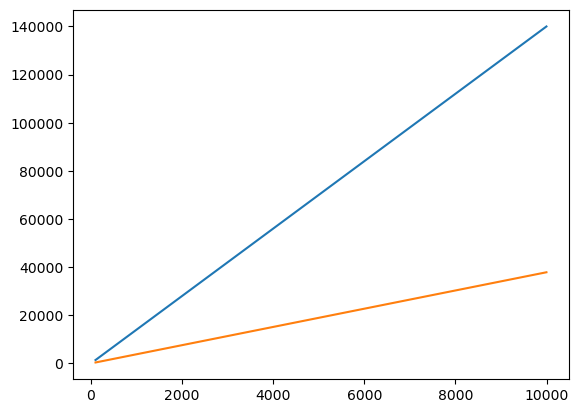

In [118]:
plt.plot(iss, num_non_adaptive_CNOTs)
plt.plot(iss, num_adaptive_CNOTs)


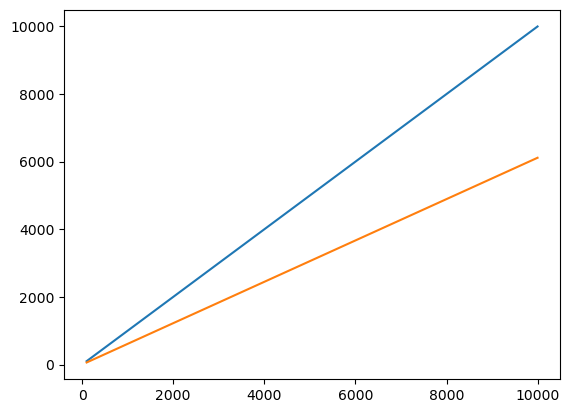

In [119]:
plt.plot(iss, num_non_adaptive_gens)
plt.plot(iss, num_adaptive_gens)